### What is this notebook trying to answer?
1. **Is perp "basis" predictable?** Funding rate is treated as a proxy for basis (premium/discount vs spot). If funding is persistent ("sticky"), basis is persistent.
1. **If it’s predictable, can you harvest it with a simple strategy?** Strategy = long spot + short perp for the coins where you expect positive funding (i.e., shorts receive funding), rotated daily into the strongest candidates.
1. **What part of PnL drives the returns?** They decompose PnL into: spot/perp price moves (basis change), funding earned, trading costs

### Load perpetual funding rate history

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Load the funding rate data from CSV
df_funding = pd.read_csv('binance_funding_rate_history.csv')

# Convert funding_time to datetime
df_funding['funding_time'] = pd.to_datetime(df_funding['funding_time'])

# Convert funding_rate and mark_price to numeric
df_funding['funding_rate'] = pd.to_numeric(df_funding['funding_rate'])
df_funding['mark_price'] = pd.to_numeric(df_funding['mark_price'])

# Create a dictionary of dataframes, one per symbol
df_by_symbol = {
    symbol: df_funding[df_funding['symbol'] == symbol].copy() 
    for symbol in df_funding['symbol'].unique()
}

# Resample to daily frequency (aggregate funding rates per day)
df_daily_list = []
for symbol, df in df_by_symbol.items():
    df_daily = (df.set_index('funding_time')
                  .resample('D')['funding_rate']
                  .sum()
                  .to_frame())
    df_daily['symbol'] = symbol
    df_daily_list.append(df_daily)

# Combine all symbols into one dataframe
df_daily = pd.concat(df_daily_list)

# Pivot to wide format for easier analysis
df_daily_wide = (df_daily.reset_index()
                         .pivot(index='funding_time', 
                                columns='symbol', 
                                values='funding_rate'))


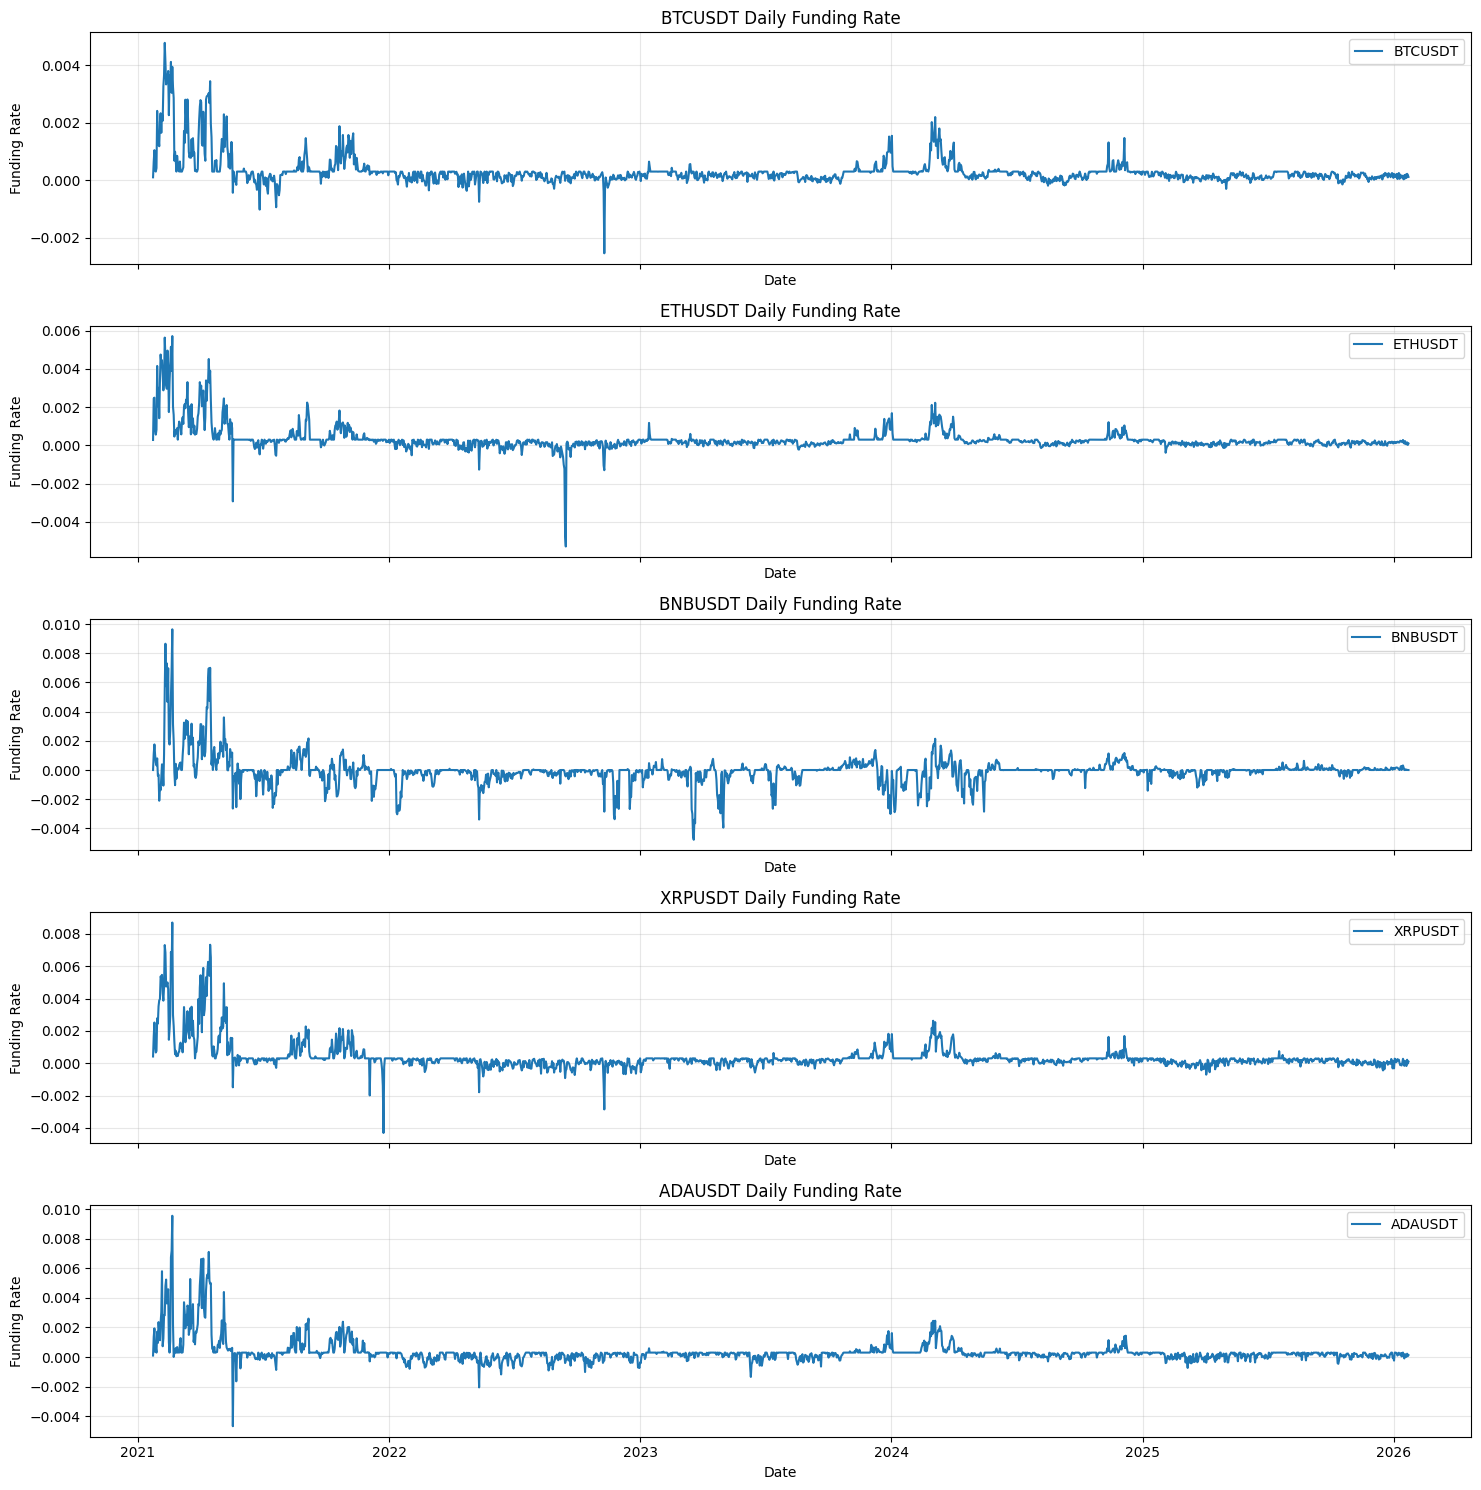

In [2]:
# Plot each symbol's daily funding rate separately

symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT']

fig, axes = plt.subplots(len(symbols), 1, figsize=(15, 3 * len(symbols)), sharex=True)

for idx, symbol in enumerate(symbols):
    axes[idx].plot(df_daily_wide.index, df_daily_wide[symbol], label=symbol)
    axes[idx].set_title(f'{symbol} Daily Funding Rate')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Funding Rate')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Testing basis predictability using ACF/PACF on funding

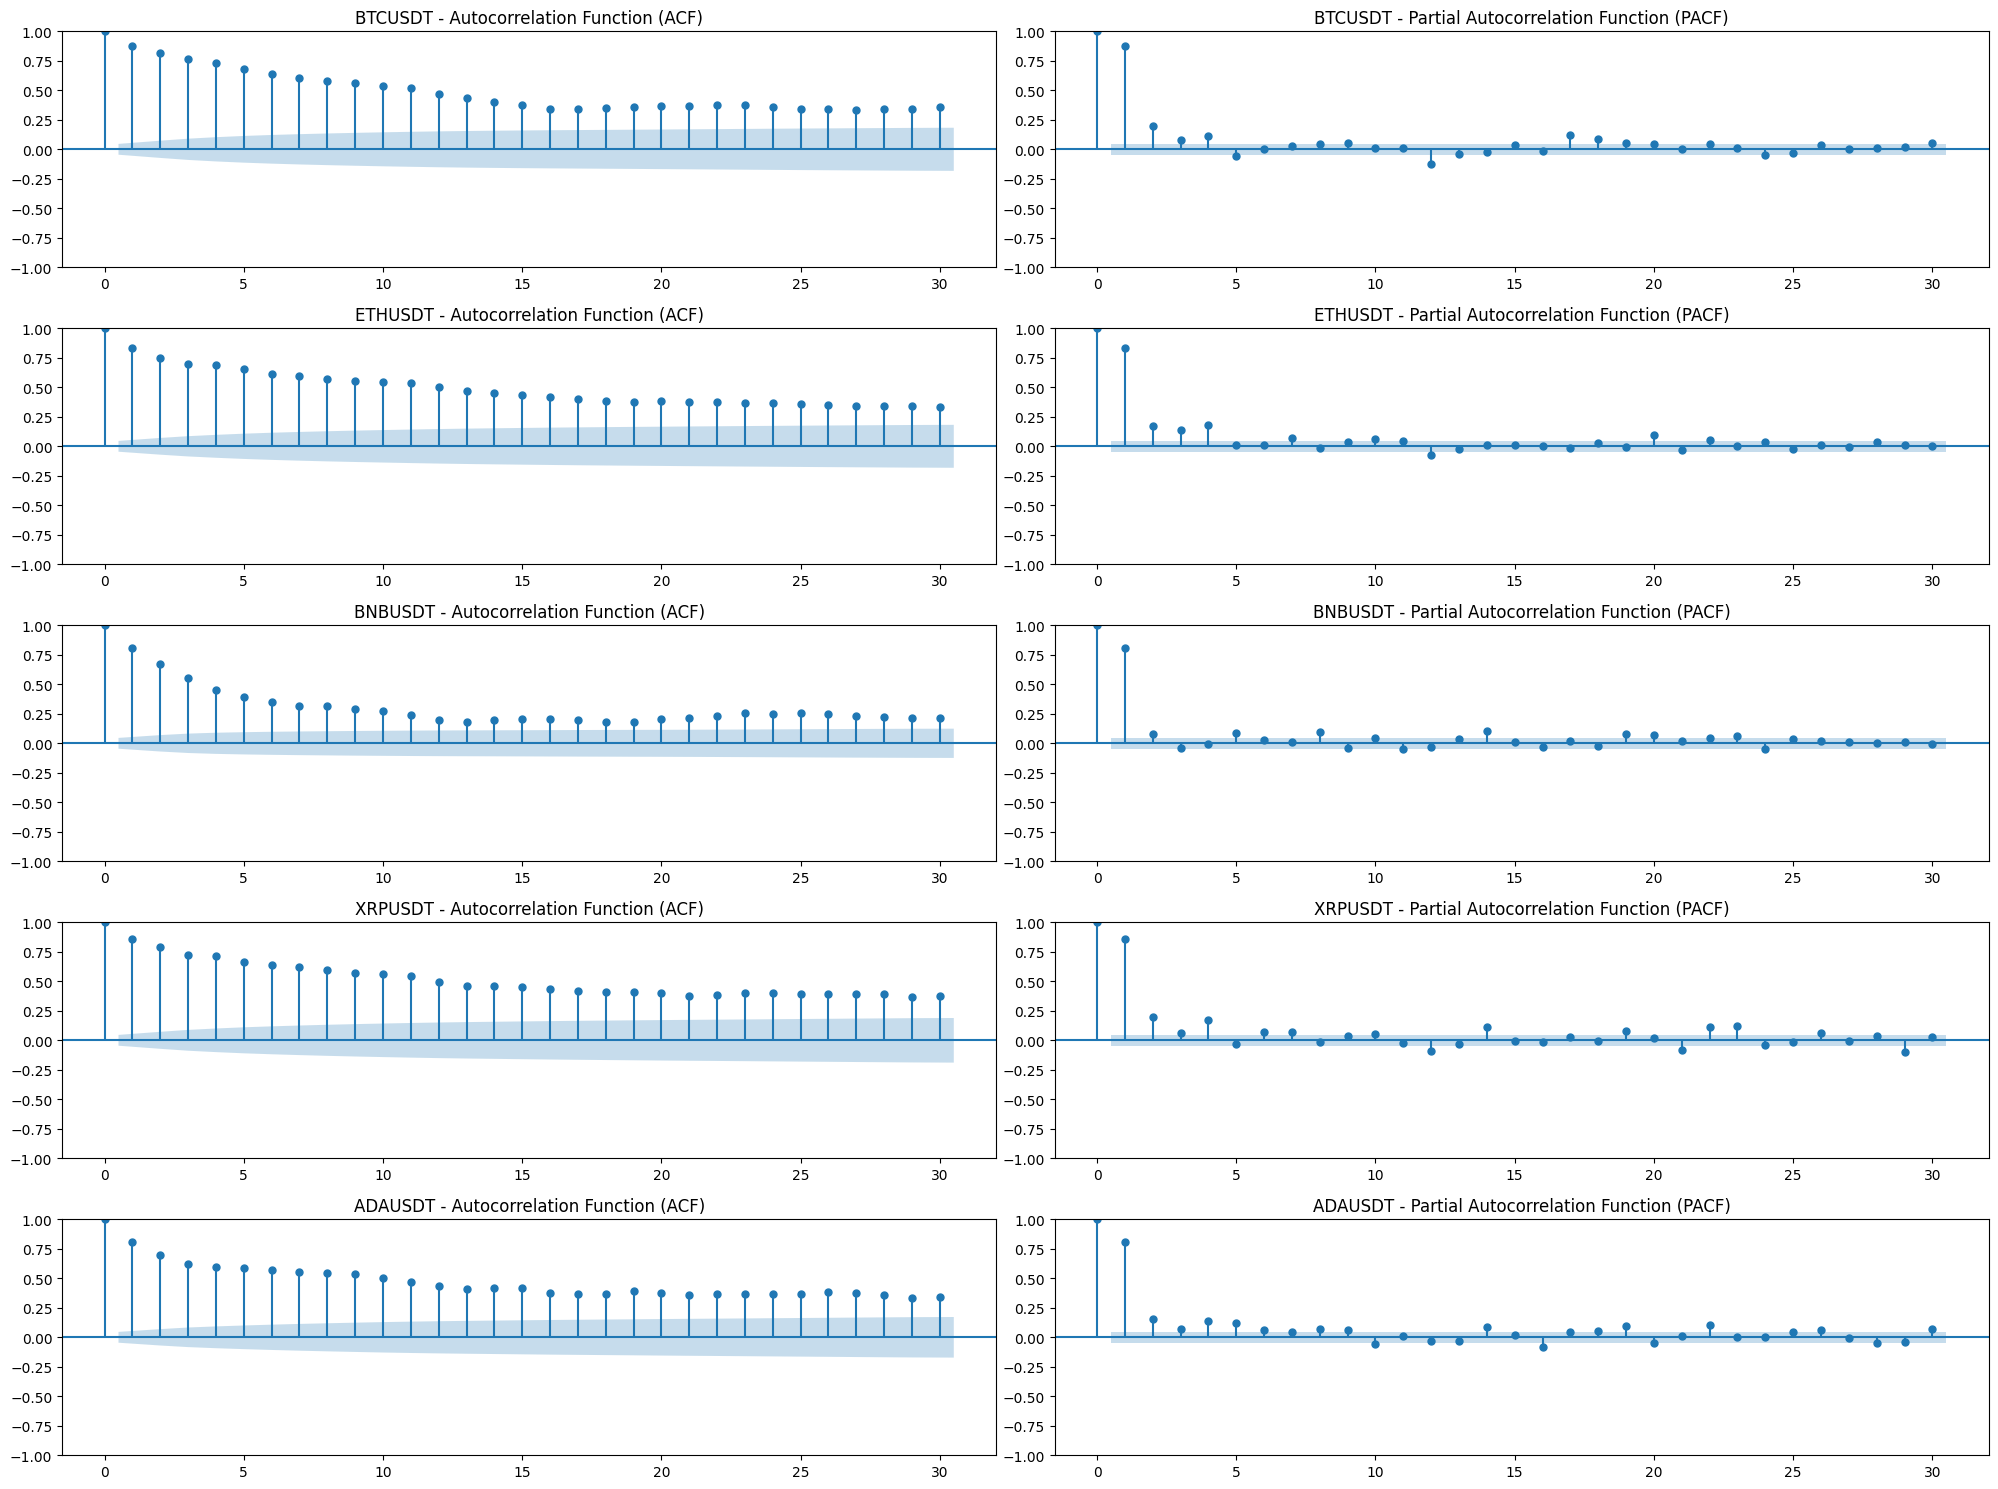

In [4]:
# Create subplots for ACF and PACF for each symbol
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'ADAUSDT']

fig, axes = plt.subplots(len(symbols), 2, figsize=(20, 3 * len(symbols)))

for idx, symbol in enumerate(symbols):
    # Plot ACF
    plot_acf(df_daily_wide[symbol].dropna(), lags=30, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{symbol} - Autocorrelation Function (ACF)')
    
    # Plot PACF
    plot_pacf(df_daily_wide[symbol].dropna(), lags=30, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{symbol} - Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### Estimating break-even holding horizon

**Logic**: To profit from funding rate arbitrage, the cumulative funding earned must exceed round-trip trading costs. The break-even holding period is approximately:

$$\text{Holding Period (days)} \approx \frac{\text{Round-trip Trading Cost (\%)}}{\text{Average Daily Funding Rate (\%)}}$$

**Binance Futures Trading Costs** (assuming VIP 0):
- Maker: 0.02% per side → **0.04% round-trip**
- Taker: 0.05% per side → **0.10% round-trip**

We'll use **0.07%** (mixed maker/taker) as a conservative estimate.